# Лабораторна робота 7

В Лекції 5, _Виявлення аномалій: методи на основі близькості_, ми розглянули способи позначення аномалій за допомогою різноманітних методів на основі відстані. Зокрема, ми розглянули використання таких методів:
- методи на основі відстані: аномалії - це точки, "далекі" від інших точок
- методи кластеризації: аномалії - це точки, які знаходяться на краях свого кластера / не належать кластеру
- методи на основі щільності: аномалії - це точки з меншою кількістю сусідів, ніж типові точки в тій самій області
- метод DBSCAN для виявлення аномалії - точки, які не входять до жодного кластера, тобто ті, що мають мало сусідів.

# Результати навчання

Ви повинні вийти з цього блокнота зі здатністю
1. Зробіть детектор аномалії kNN (на основі відстані)
2. Створіть детектор аномалії k-середніх (на основі кластера)
3. Використовуйте коефіцієнт локального викиду для класифікації аномалій
4. Застосуйте Density-Based Spatial Clustering of Applications with Noise


# Імпорт

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets as sk_data
import sklearn.neighbors as neighbors
import sys

np.set_printoptions(suppress=True, precision=4)

## Розділ 1: Методи на основі відстані

 Найпростіший метод найближчого сусіда (NN) полягає в тому, щоб прийняти відстань до k-найближчого сусіда як показник аномалії. Наступним варіантом є використання середнього значення відстаней до перших k сусідів як оцінка. `sklearn` надає `neighbors.NearestNeighbors` для обчислення найближчих сусідів із набору даних. Після підгонки ми можемо використовувати `kneighbors()`, щоб повернути відстані та індекси верхніх k сусідів. Ми можемо використати `kneighbors_graph()`, щоб повернути весь графік зв’язності (як масив, де 1 вказує на посилання) для набору даних. Граф — це розріджений масив, але з ним можна працювати так само, як і зі звичайним (щільним) масивом. Якщо вам потрібен звичайний масив, ви можете використовувати `todense()`, щоб зробити його щільним.

Ідея для моделей kNN така
- подивіться на $k$ сусідів кожної точки
- виставити оцінку. Приблизно, низька оцінка означає, що $k$ сусіди точки близькі.
- існує кілька способів визначення оцінок:
     - максимальна відстань (тобто відстань до $k$-го найближчого сусіда)
     - середнє $k$ відстаней
     - середнє гармонічне $k$ відстаней.

Використовуйте оцінку, щоб визначити, чи є щось аномалією, використовуючи або _threshold_, або _ranking_.

Ми почнемо зі створення простого набору даних з однією аномалією, а потім побудуємо графік даних.

In [24]:
X = np.array([[0.9, 1], [0, 1], [1, 0], [0, 0], [0.5, 0.5], [0.2, 0.5], [1, 0.5], [2, 2]])

plt.figure(dpi=150)
plt.title('Upper right point looks anomalous')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.plot(X[:, 0], X[:, 1], 'o');

In [25]:
#import sklearn
#print(sklearn.show_versions())

Давайте створимо функцію для більш чіткогї візуалізації точки запиту та її сусідів.

In [26]:
def plot_point_and_k_neighbors(X, highlight_index, n_neighbors=2):  #highlight_index  - індекс точки з вихідних даних
    "Plots the points in X, and shows the n_neighbors of the highlight_index-th point"
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors).fit(X) #визначає сусідів
    dist, index = nn.kneighbors()  #дає дистанцію та індекси сусідів для кожної точки
    
    src_pt = X[highlight_index, :]
    
    plt.figure(dpi=150)
    # draw lines first, so points go on top
    for dest_index in index[highlight_index]:
        dest_pt = X[dest_index, :]
        plt.plot(*list(zip(src_pt, dest_pt)), 'k--')
    plt.plot(X[:, 0], X[:, 1], 'o', label='Not k-neighbors', alpha=0.3)
    plt.plot(*src_pt, 'o', label='The query point')
    plt.plot(X[index[highlight_index], 0], X[index[highlight_index], 1], 'o', label='k-neighbors')
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    plt.legend()
    
# Example of usage
plot_point_and_k_neighbors(X, 0, 4)

Тут ми бачимо, що 4 точки, близькі до точки запиту (індекс 0 у наших даних), відносно близькі. 

Давайте подивимося на аномальну точку вгорі праворуч (ця точка має індекс 7):

In [27]:
aa = neighbors.NearestNeighbors(n_neighbors=4).fit(X) #визначає сусідів
dist, index = aa.kneighbors()
print(dist, index)
print('Координати усіх восьми точок',X)
print('Координати  точки з індексом 7',X[7, :])
print('Індекси сусідніх точок для точки з індексом 7',index[7])
print('Відстані від точки з індексом 7 до сусідніх точок',dist[:,-1])

[[0.5099 0.6403 0.8602 0.9   ]
 [0.5385 0.7071 0.9    1.    ]
 [0.5    0.7071 0.9434 1.    ]
 [0.5385 0.7071 1.     1.    ]
 [0.3    0.5    0.6403 0.7071]
 [0.3    0.5385 0.5385 0.8   ]
 [0.5    0.5    0.5099 0.8   ]
 [1.4866 1.8028 2.1213 2.2361]] [[6 4 5 1]
 [5 4 0 3]
 [6 4 5 3]
 [5 4 1 2]
 [5 6 0 3]
 [4 1 3 6]
 [4 2 0 5]
 [0 6 4 1]]
Координати усіх восьми точок [[0.9 1. ]
 [0.  1. ]
 [1.  0. ]
 [0.  0. ]
 [0.5 0.5]
 [0.2 0.5]
 [1.  0.5]
 [2.  2. ]]
Координати  точки з індексом 7 [2. 2.]
Індекси сусідніх точок для точки з індексом 7 [0 6 4 1]
Відстані від точки з індексом 7 до сусідніх точок [0.9    1.     1.     1.     0.7071 0.8    0.8    2.2361]


In [28]:
plot_point_and_k_neighbors(X, 7, n_neighbors=4)

У цьому випадку ми бачимо, що всі 4 найближчі сусіди до нашої точки знаходяться далеко, тому здається досить однозначним назвати цю точку аномалією.

Давайте додамо ще одну точку до аномалії та подивимось, як вибір «k» і функція підрахунку оцінок впливають на аналіз.

In [29]:
# Набір даних з двома суміжними аномаліями
X2 = np.concatenate([X, [[1.9, 2.0]]])

# Подивіться на найближчого сусіда (k=1)
plot_point_and_k_neighbors(X2, 7, n_neighbors=1)

### Спостереження 1: залежність від $k$

Відстань між точкою 7 і новою точкою насправді досить мала — менша, ніж відстані між будь-якою парою точок у нижньому лівому куті. Якщо $k=1$, дві точки у верхньому правому куті будуть _останніми_, які класифікуватимуться як аномалія (тобто вони матимуть найнижчу оцінку).

### Спостереження 2: як зважити відстані?

Давайте подивимося на той самий набір даних (тобто з додатковою точкою), але тепер подивимося на $k=3$

In [30]:
plot_point_and_k_neighbors(X2, 7, n_neighbors=3)

Ми бачимо, що один із 3 найближчих сусідів дуже близько, а два інших далеко. Нам потрібен якийсь спосіб об’єднати ці 3 відстані в оду оцінку. Три широко використовувані методи:
1. Використовуйте найбільшу відстань
2. Використовуйте (арифметичне) середнє відстань
3. Використовуйте середнє гармонічне.

Ми реалізуємо найдовшу відстань, а  середню арифметичну відстань і середню гармонічну відстань виконаєте як вправи нище.

#### Використання найдовшої відстані

In [31]:
def do_nn_outlier_scores(obs, n_neighbors=1):
    """
    Дає оцінку точки як відстань від точки до її k-го найближчого сусіда.
     Більша оцінка означає більшу ймовірність викиду
    """
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(obs)
    dists, idx = nn.kneighbors()
    scores = dists[:,-1] # останній стовпчик матриці містить найбільші відстані до сусідів
    return scores

# Test 
do_nn_outlier_scores(X2, n_neighbors=3)

array([0.8602, 0.9   , 0.9434, 1.    , 0.6403, 0.5385, 0.5099, 1.8028,
       1.7493])

Можемо зробити виведення трохи легшим для розуміння

In [32]:
def print_ranked_scores(obs, scores):
    scores_and_obs = sorted(zip(scores, obs), key=lambda t: t[0], reverse=True) # обєднали два кортежі даних і відсортували по відстін
    print('Rank  Point\t\tScore')
    print('------------------------------')
    for index, score_ob in enumerate(scores_and_obs):
        score, point = score_ob
        print(f'{index+1:3d}.  {point}\t\t{score:6.4f}')

# Подивіться на викиди, використовуючи 3 сусідніх
print_ranked_scores(X2, do_nn_outlier_scores(X2, 3))

Rank  Point		Score
------------------------------
  1.  [2. 2.]		1.8028
  2.  [1.9 2. ]		1.7493
  3.  [0. 0.]		1.0000
  4.  [1. 0.]		0.9434
  5.  [0. 1.]		0.9000
  6.  [0.9 1. ]		0.8602
  7.  [0.5 0.5]		0.6403
  8.  [0.2 0.5]		0.5385
  9.  [1.  0.5]		0.5099


Тепер подивіться на аномалії з k=1

In [33]:
print_ranked_scores(X2, do_nn_outlier_scores(X2, 1))

Rank  Point		Score
------------------------------
  1.  [0. 1.]		0.5385
  2.  [0. 0.]		0.5385
  3.  [0.9 1. ]		0.5099
  4.  [1. 0.]		0.5000
  5.  [1.  0.5]		0.5000
  6.  [0.5 0.5]		0.3000
  7.  [0.2 0.5]		0.3000
  8.  [2. 2.]		0.1000
  9.  [1.9 2. ]		0.1000


**Зауваження:** Кількість сусідів $k$, що використовуються в kNN, різко змінює результати. Зазвичай потрібен певний досвід у цій галузі, щоб знати значення $k$ або діапазон значень для $k$, які потрібно використовувати.

# kNN у зворотному напрямку: виявлення викидів за допомогою ступеня (ODIN)

Інший варіант, заснований на відстані, називається ODIN (виявлення викидів за допомогою ступеня), використовує тих самих сусідів іншим способом. Як обговорювалося в лекції, цей алгоритм ставить запитання «чи я є найближчим сусідом?». Отже, точка, яка служить Найблищим сусідом для багатьох інших – з великою кількістю зв'язків на графіку найблищих сусідів – має *низьку* оцінку аномалії. Точки з невеликим ступенем (= # вхідних посилань), швидше за все, будуть аномаліями.

Ось реалізація ODIN. Зауважте, що ми перетворюємо оцінки довільного ступеня (низького для аномалії) на шкалу від нуля до одного, де вищі значення є більшою аномалією.

In [34]:
def do_odin_outlier_scores(obs, n_neighbors=3):
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors).fit(obs)
    graph = nn.kneighbors_graph() #Обчисліть (зважений) графік k-сусідів для точок у X, де A[i, j] присвоєно вагу ребра, яке з’єднує i з j. Матриця має формат CSR.
    indegree = graph.sum(axis=0)  # sparse matrix сумування по стовпцях

    # менший ступінь означає більшу аномалію
     # просте перетворення в [0,1], тож більша оцінка є більшою аномалією
    scores = (indegree.max() - indegree) / indegree.max()
    return np.array(scores)[0]  # convert to array

Оцініть і проранжуйте точки для набору даних X2 (дві сусідні аномалії).

In [35]:
scores_odin= do_odin_outlier_scores(X2)

In [36]:
print_ranked_scores(X2, scores_odin)

Rank  Point		Score
------------------------------
  1.  [0. 1.]		0.8333
  2.  [0. 0.]		0.8333
  3.  [2. 2.]		0.8333
  4.  [1.9 2. ]		0.8333
  5.  [1. 0.]		0.6667
  6.  [0.9 1. ]		0.1667
  7.  [0.2 0.5]		0.1667
  8.  [1.  0.5]		0.1667
  9.  [0.5 0.5]		0.0000


Дві аномалії (2, 2) і (1,9, 2) мають високі оцінки, але також точки (0, 1) і (0, 1). Крім того, результат відрізняється від того, який ми знайшли з результатами k-середніх. Як ми обговорювали на лекції, метод, який ви використовуєте, має значення.

# Розділ 2: Кластерний метод (k-середні)

 Кластеризація за допомогою k-середніх може бути використана як метод виявлення аномалій:

   1. генерація кластерів,
   2. знаходження кластера (кожна точка відноситься до свого кластеру),
   3. використовуючи відстань від точки до центру його кластера як оцінку.
  
Ці етапи доступні за допомогою `cluster.KMeans`, який після підгонки та прогнозування для отримання кластерів — як розташування кластерів, так і того, до якого кластера належить точка — надає атрибут `cluster_centers_`. Тоді ми можемо використовувати `numpy.linalg.norm` numpy (часто імпортований як `import numpy.linalg as nla`) для обчислення відстаней.

Ми почнемо з генерації деяких даних, потім покажемо, що таке кластери, і, нарешті, оцінимо аномалії.

### Генерація та перегляд даних

In [37]:
blobs_X, cluster_labels = sk_data.make_blobs(centers=[[0,0], [10,10], [10,0]])
anomalies, _ = sk_data.make_blobs(centers=[[5,5]], n_samples=5, cluster_std=3, random_state=42)

data = np.concatenate([blobs_X, anomalies])
cluster_labels = np.concatenate([cluster_labels, [-1]*len(anomalies)])

# Display the data before clustering
plt.figure(dpi=110)
plt.plot(data[:, 0], data[:, 1], 'o');

#### Кластеризація та показати позначення кластера

In [38]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3).fit(data)

plt.figure(dpi=120)

for label in range(3):
    mask = (km.labels_ == label)
    plt.plot(data[mask, 0], data[mask, 1], 'o', label=f'Cluster {label}')
plt.legend();

D:\minicond\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Ви повинні запустити кластеризацію кілька разів і зауважити, що призначення деяких точок змінюється через різні початкові умови (випадковий вибір початкових центроїдів).

#### Для кожної точки знайдіть відстань від неї до її центроїда

In [39]:
centers = km.cluster_centers_[km.labels_]
# покажіть центри для перших 10 точок
centers[:10]

array([[ 0.2313,  0.2626],
       [ 0.2313,  0.2626],
       [10.2635,  9.8213],
       [ 9.7964, -0.1742],
       [10.2635,  9.8213],
       [10.2635,  9.8213],
       [ 9.7964, -0.1742],
       [ 9.7964, -0.1742],
       [ 0.2313,  0.2626],
       [ 0.2313,  0.2626]])

In [40]:
#Отримайте відстані до центрів і використовуйте їх як оцінки
score = np.linalg.norm(data - centers, axis=1)
score

array([2.435 , 1.796 , 0.8144, 0.576 , 1.5226, 1.1888, 1.4464, 1.8018,
       0.9897, 0.362 , 1.3206, 1.1713, 2.2419, 1.0281, 1.9222, 2.3998,
       1.7963, 2.1896, 3.0487, 0.934 , 0.5765, 1.2098, 0.5643, 1.6013,
       2.2852, 1.0628, 0.5172, 2.0496, 1.2547, 0.2376, 0.7178, 1.6628,
       1.027 , 0.7567, 2.9811, 0.7079, 1.2508, 0.8707, 0.6455, 0.5329,
       1.6399, 0.786 , 0.7653, 1.3688, 0.3778, 2.0951, 1.2895, 1.998 ,
       1.3113, 0.6201, 1.4281, 0.6005, 1.0589, 1.2196, 1.3022, 0.4596,
       0.4139, 0.5432, 2.1918, 2.5688, 1.7712, 1.2192, 1.6099, 1.4228,
       1.9072, 0.8788, 2.9497, 2.0208, 1.2131, 0.1924, 1.6202, 0.3266,
       0.8064, 1.6419, 2.2173, 1.7841, 0.2951, 1.6884, 1.2814, 0.7256,
       2.4555, 2.6425, 1.8409, 1.8488, 1.8534, 1.1905, 1.6771, 1.2494,
       1.2896, 0.8961, 1.7583, 1.6743, 0.7935, 0.5211, 1.0425, 1.3273,
       1.288 , 1.7803, 2.6795, 0.4633, 5.7285, 3.33  , 7.1976, 5.7951,
       2.5733])

Які 5 точок мають найвищі оцінки? Назвемо це аномаліями

In [41]:
np.argsort(score)[::-1][:5]

array([102, 103, 100, 101,  18], dtype=int64)

Покажіть ці результати на графіку (5 точок), який включає центри кластерів (позначені «x»)

In [42]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3).fit(data)

anomaly_idx = np.argsort(score)[::-1][:5]
anomaly_mask = np.zeros(len(data))
anomaly_mask[anomaly_idx] = 1

plt.figure(dpi=120)
colors = ['blue', 'orange', 'green']

for label, color in enumerate(colors):
    mask = (km.labels_ == label) & (anomaly_mask == 0)
    plt.plot(data[mask, 0], data[mask, 1], marker='o', linestyle='none',
             color=color, label=f'Кластер {label}')
    plt.plot(*km.cluster_centers_[label], marker='x', color='k')

plt.plot(data[anomaly_idx, 0], data[anomaly_idx, 1], marker='o', linestyle='none',
         color='k', label='Anomaly')
plt.legend();

D:\minicond\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Якщо ви повторно запустите кластеризацію достатньо разів, ви побачите, що три центральні точки завжди позначені як аномалії. Інші дві аномалії відрізняються залежно від того, як точки згруповані.

**Примітка**: якщо змінювати кількість кластерів, можна очікувати навіть більших змін. Нижче ми проілюструємо ефект зміни кількості кластерів від 1 до 5.

In [43]:
# Show clustering for user-specified number of clusters
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,5, figsize=(15,3))
for ax, n_clusters in zip(axes, [1,2,3,4,5]):
    clust = KMeans(n_clusters=n_clusters)
    obs_to_clusters = clust.fit_predict(data) 
    ax.scatter(*data.T, c=obs_to_clusters)
    ax.set_title("n_clusters={}".format(n_clusters))

D:\minicond\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\minicond\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\minicond\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\minicond\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

# Розділ 3: Методи на основі щільності (фактор локального викиду)

Фактор локального викиду (LOF) є `sklearn` має версію, доступну для використання. Зауважте, що LOF, який повертає `sklearn`, є негативним значенням, яке ми визначили в лекції.

Застосуйте LOF до набору точок ('X2'), яку ми створили в розділі 1.

In [44]:
import sklearn.neighbors as neighbors
lof = neighbors.LocalOutlierFactor(n_neighbors=3, contamination='auto')
lof.fit(X2)
sk_lof = -lof.negative_outlier_factor_
print_ranked_scores(X2, sk_lof)

Rank  Point		Score
------------------------------
  1.  [2. 2.]		1.8608
  2.  [1.9 2. ]		1.8293
  3.  [0.2 0.5]		1.2154
  4.  [1.  0.5]		1.2091
  5.  [0. 0.]		1.0333
  6.  [0. 1.]		1.0120
  7.  [1. 0.]		0.9554
  8.  [0.9 1. ]		0.8891
  9.  [0.5 0.5]		0.8272


Перегляньте значення як вище, так і нижче 1. Як обговорювалося в лекції, ми очікуємо, що значення, значно вище 1, є аномаліями.

Порівняйте з попередніми результатами kNN. Зверніть увагу, що ми використовуємо однакове значення k (=3) для обох алгоритмів.

In [45]:
print_ranked_scores(X2, do_nn_outlier_scores(X2, 3))

Rank  Point		Score
------------------------------
  1.  [2. 2.]		1.8028
  2.  [1.9 2. ]		1.7493
  3.  [0. 0.]		1.0000
  4.  [1. 0.]		0.9434
  5.  [0. 1.]		0.9000
  6.  [0.9 1. ]		0.8602
  7.  [0.5 0.5]		0.6403
  8.  [0.2 0.5]		0.5385
  9.  [1.  0.5]		0.5099


Дві аномальні точки знайдено обома способами, але результати для інших точок відрізняються.

Для повноти ми надаємо нижче явну реалізацію LOF, яка відповідає плану, наведеному в лекції. Щоб переконатися, що наш алгоритм є розумним, ми порівнюємо результати для оцінки аномалії з результатами версії `sklearn` для cluster blobs ('data') (кластерних крапель ('даних')).

In [46]:
def lof_method(obs, n_neighbors=2):
    neigh = neighbors.NearestNeighbors(n_neighbors=2).fit(obs)
    
    #Поверніть індекси та відстані до сусідів кожної точки
    topk_dist, my_kneigh = neigh.kneighbors()
    
    # Створіть список відстаней найдальшого (k-го) сусіда
    k_dist = topk_dist[:,-1]
 
    # Відстань досяжності: максимальна справжня відстань між сусідом запиту та точкою запиту
     # і відстань до k-го найближчого сусіда запитуваного сусіда
    reach = np.maximum(topk_dist, k_dist[my_kneigh])
    
    # Local reacability density Щільність локальної доступності є зворотною величиною середньої відстані доступності
    lrd = 1.0 / np.mean(reach, axis=1)
    
    # LOF Коефіцієнт локального викиду визначається як
    # середня локальна щільність сусідів / локальна щільність точки запиту
    # average local density of neighbors / local density of query point
    lrd_ratios = lrd[my_kneigh] / lrd[:, np.newaxis]
    lof = np.mean(lrd_ratios, axis=1)
    
    return lof

In [47]:
# Choose k=2
our_lof = lof_method(data, 2)
our_lof

array([1.0864, 2.0101, 1.0753, 0.9345, 2.0075, 0.8643, 1.0532, 1.1518,
       1.0472, 1.2736, 1.0171, 0.9519, 0.967 , 1.0165, 1.0004, 1.3003,
       0.9662, 0.9818, 4.1687, 1.1293, 1.1387, 1.2388, 1.4152, 0.9157,
       1.0732, 0.9338, 0.9345, 1.0785, 1.1657, 1.6291, 1.0754, 1.2397,
       0.9404, 0.947 , 1.8609, 1.0596, 0.9154, 1.7034, 0.9719, 1.1678,
       1.1633, 1.4558, 0.9823, 1.1973, 1.1877, 1.3003, 3.3291, 1.0052,
       0.9019, 1.1753, 1.2441, 0.9282, 1.1525, 0.9389, 0.919 , 0.9331,
       1.1546, 1.5607, 1.1518, 2.0859, 1.0871, 1.047 , 0.9891, 0.9019,
       1.731 , 0.9719, 1.1207, 1.731 , 1.1186, 1.705 , 1.0818, 1.5839,
       1.1508, 1.456 , 1.0052, 1.1633, 0.9331, 1.0532, 0.8836, 1.1247,
       0.953 , 1.4598, 1.456 , 1.5203, 1.0818, 0.9338, 1.0706, 0.919 ,
       1.0874, 0.9345, 0.967 , 2.3285, 1.0754, 1.0847, 1.0558, 1.1933,
       0.947 , 1.092 , 1.4598, 0.9282, 1.1858, 1.3897, 0.9217, 0.9217,
       1.1641])

In [48]:
lof2 = neighbors.LocalOutlierFactor(n_neighbors=2, contamination='auto')
lof2.fit(data)
sk_lof2 = -lof2.negative_outlier_factor_
print('Результат такий же, як і в sklearn?', np.allclose(our_lof, sk_lof2))

Результат такий же, як і в sklearn? True


# Розділ 4: Методи на основі щільності (DBSCAN)

In [49]:
from sklearn.cluster import DBSCAN

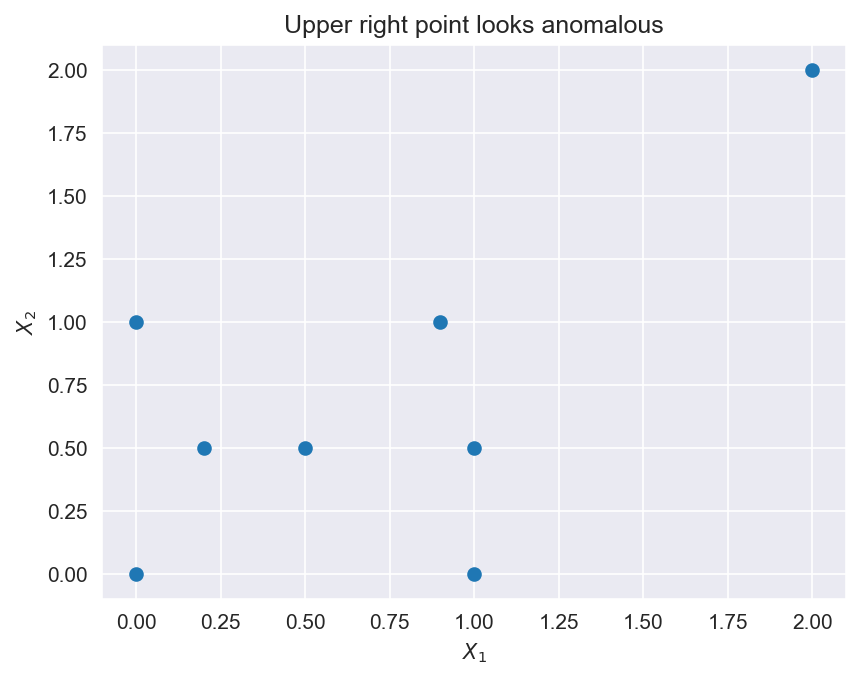

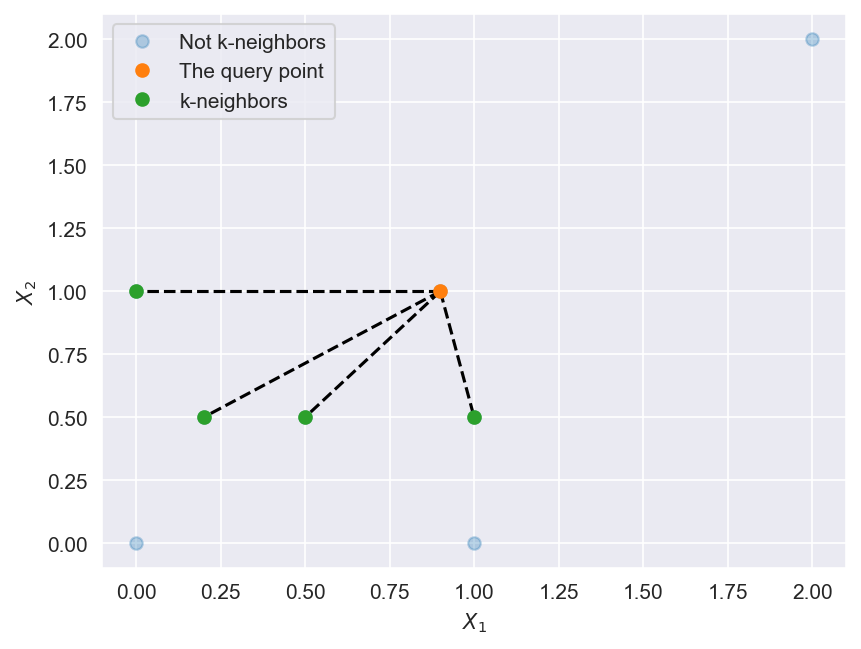

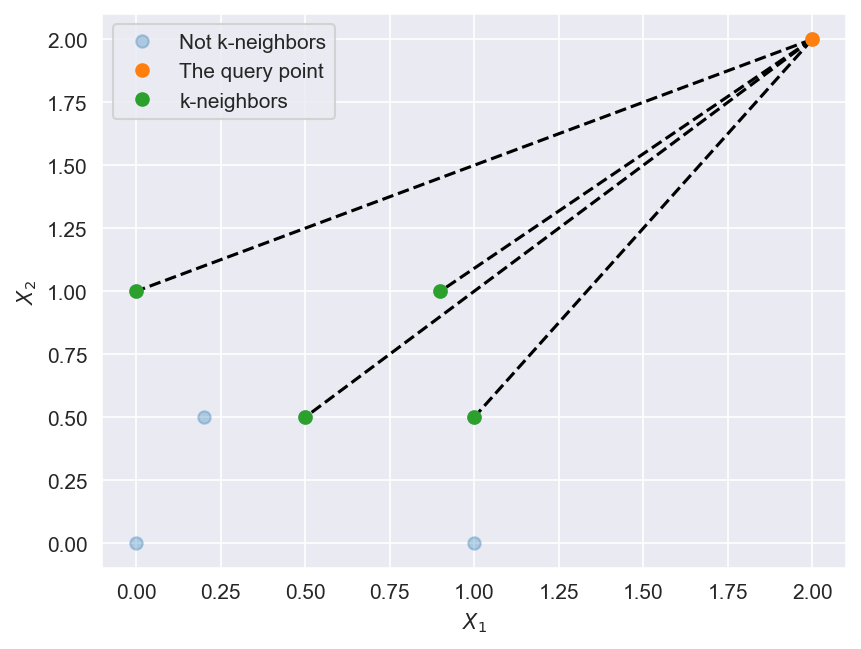

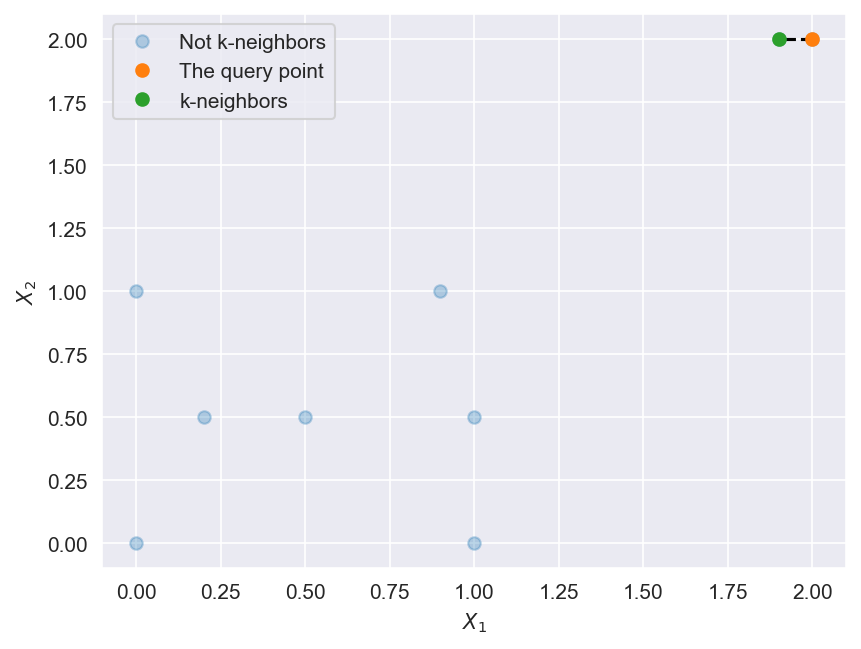

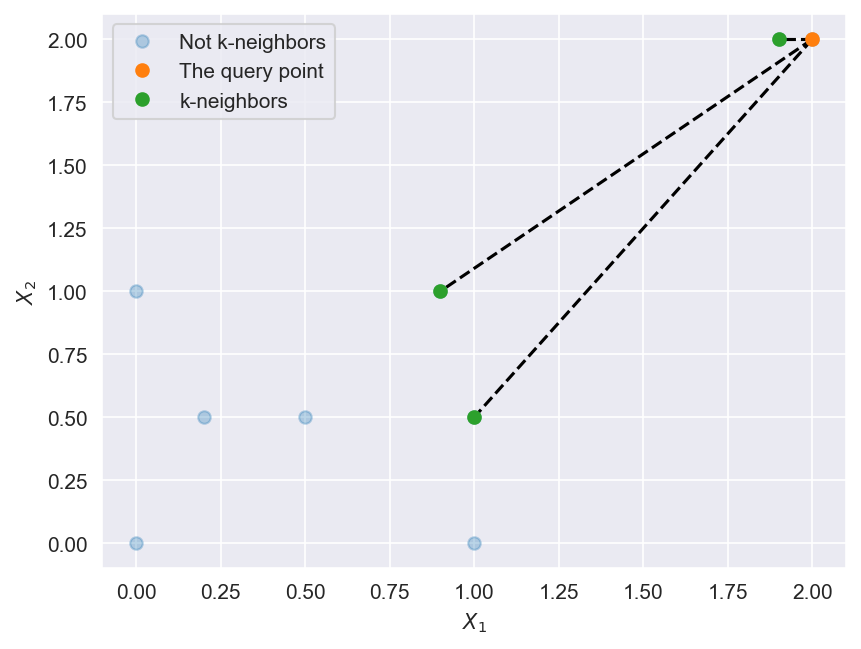

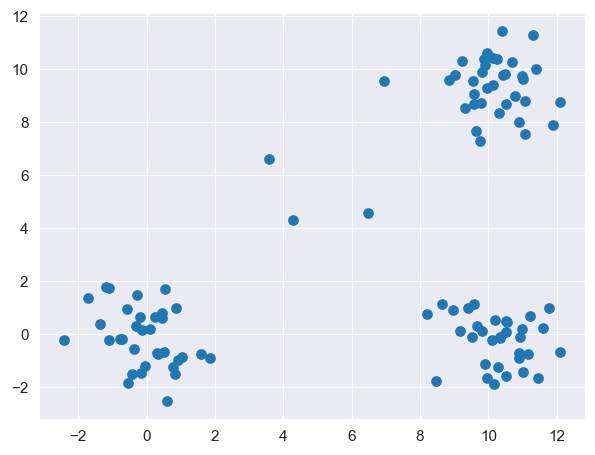

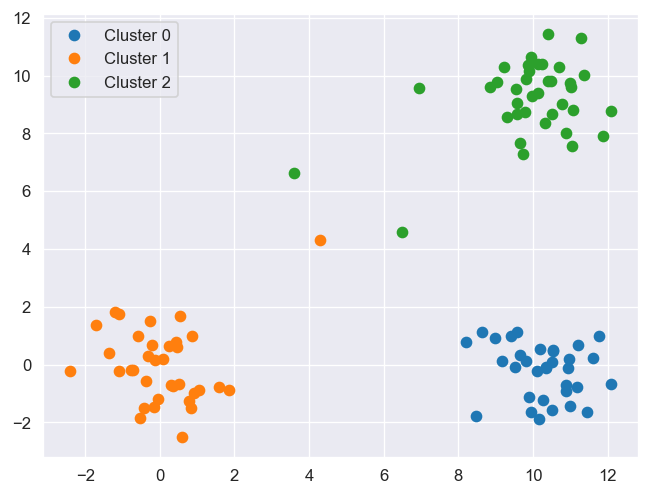

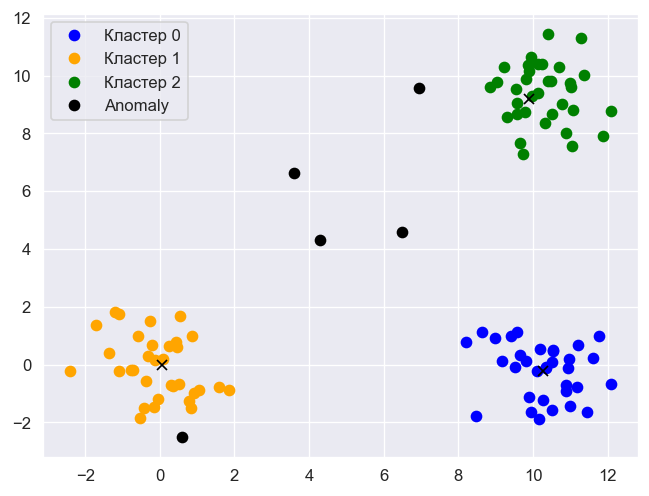

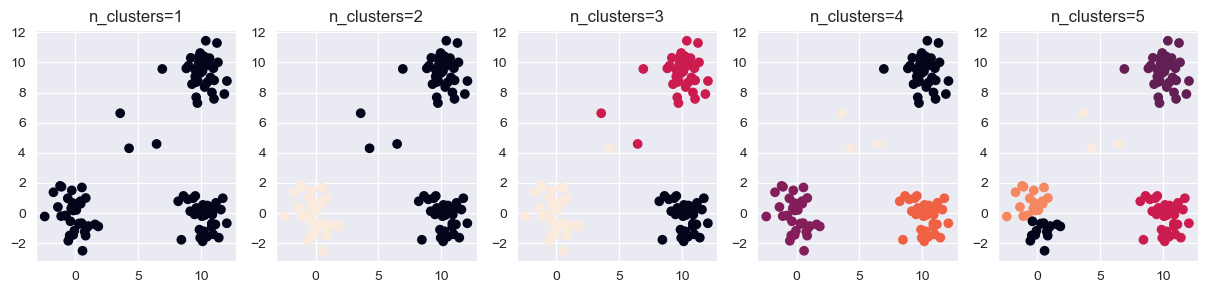

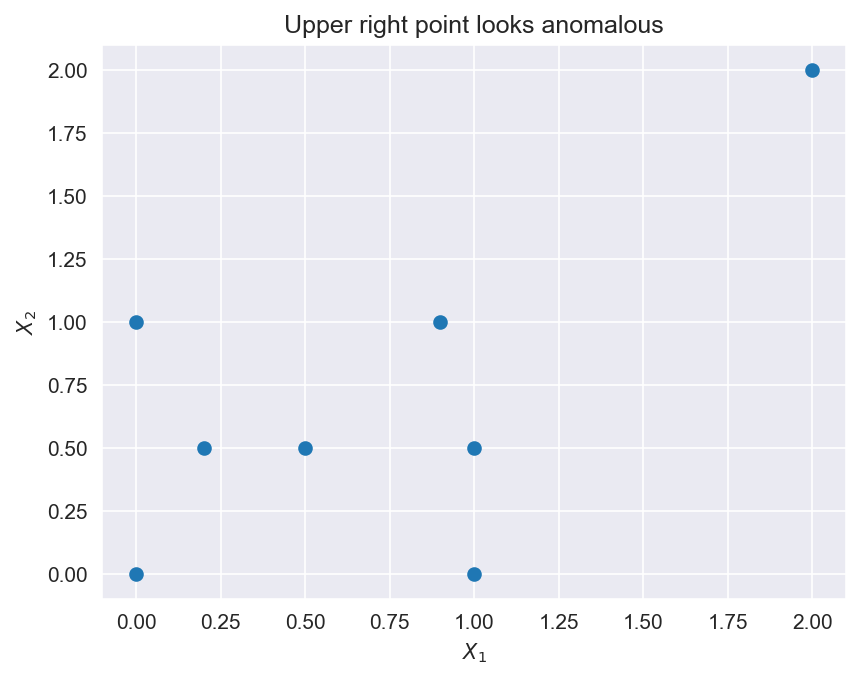

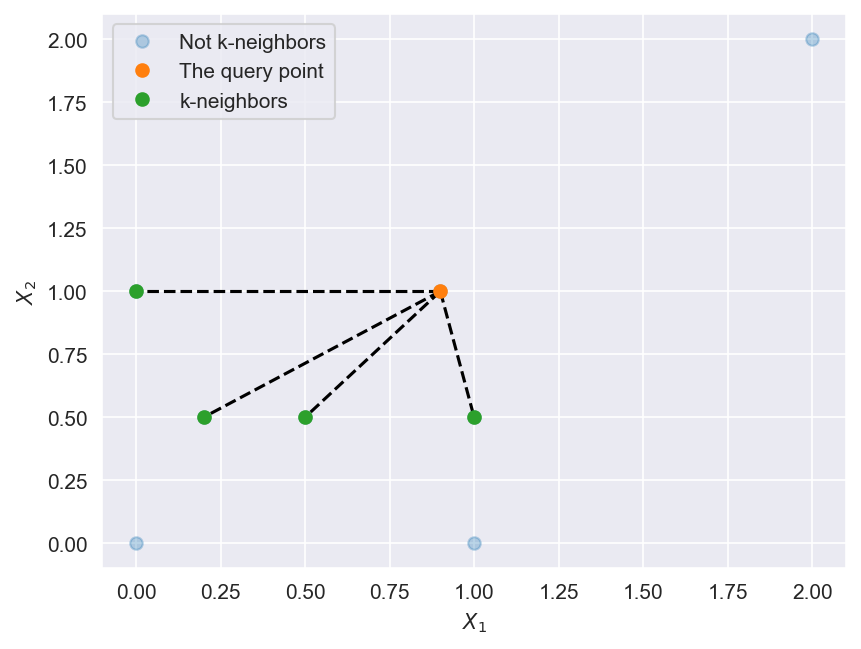

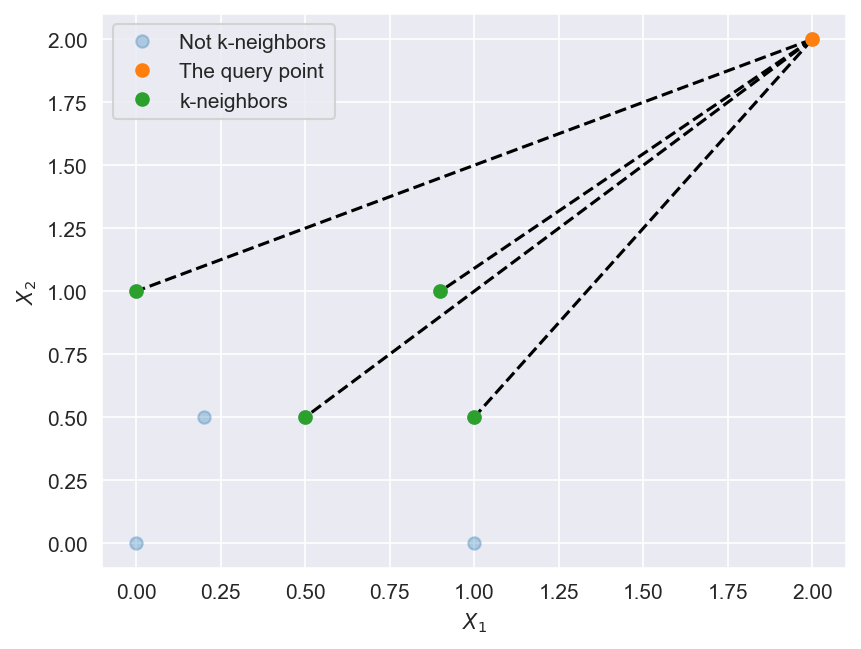

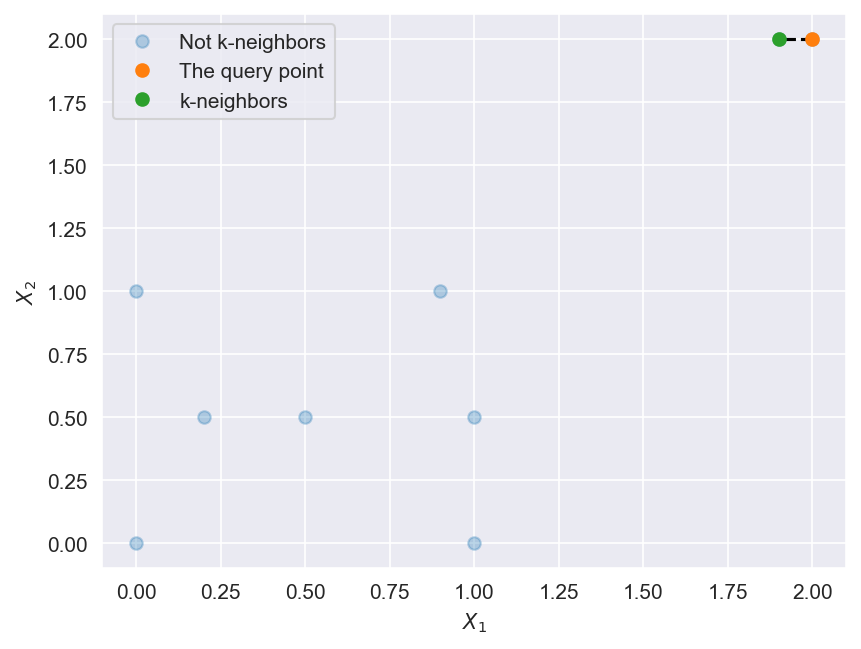

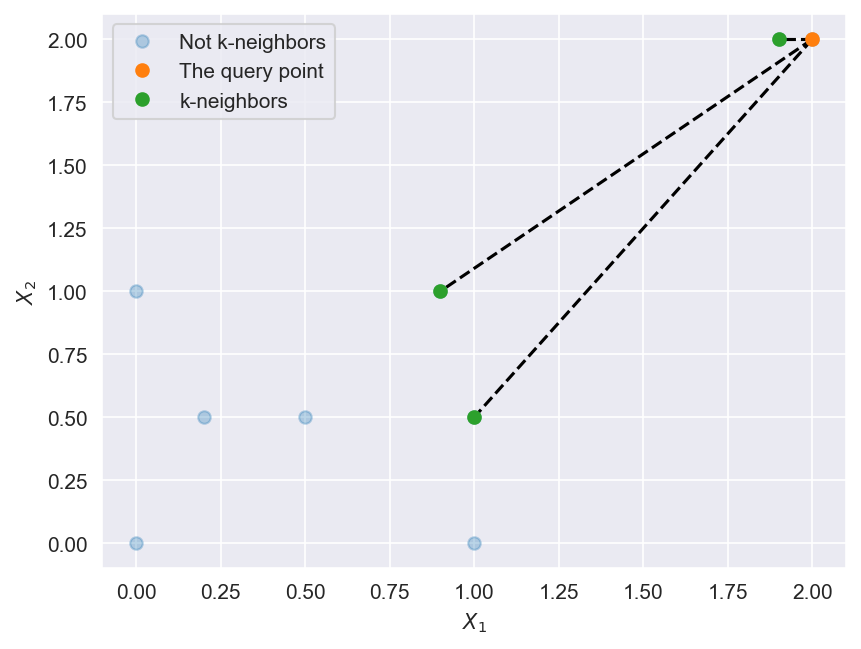

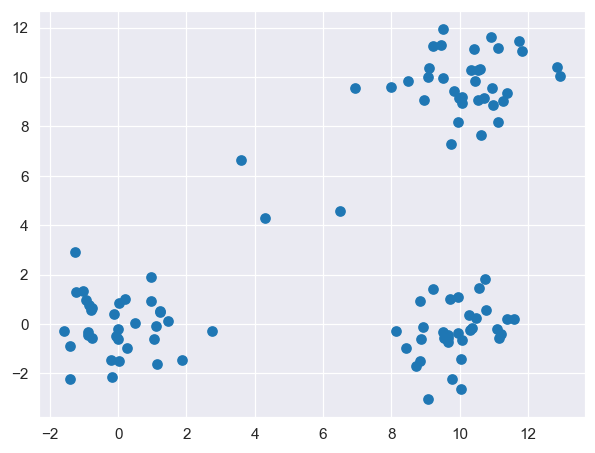

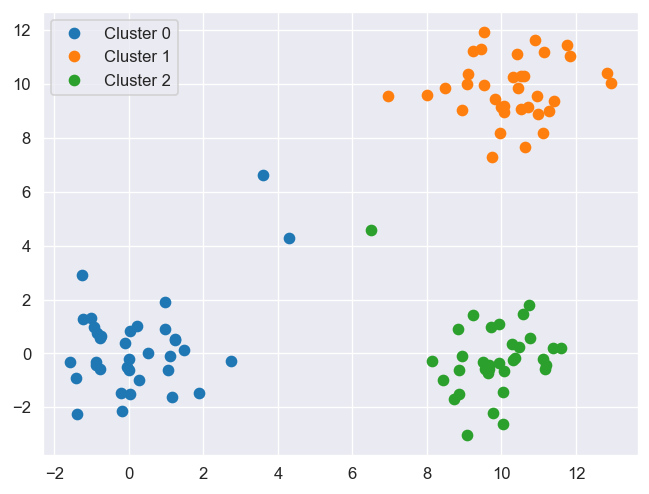

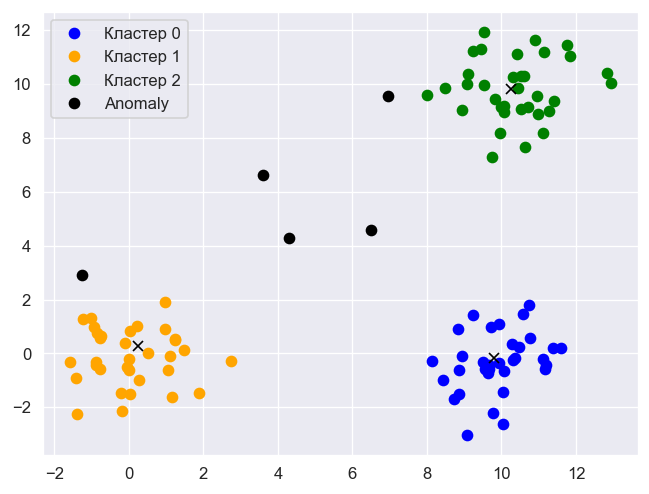

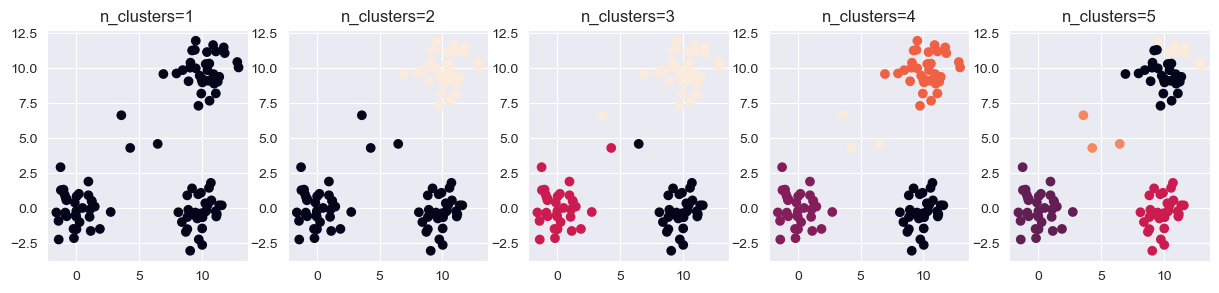

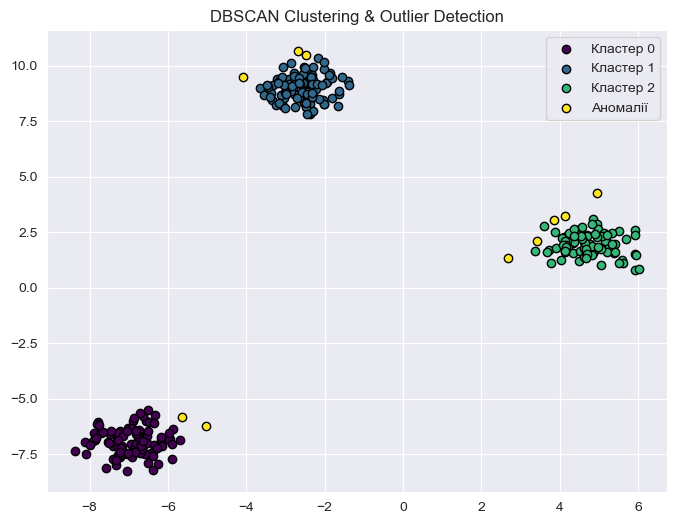

In [50]:
# Генерація тестових даних
X, _ = sk_data.make_blobs(n_samples=300, centers=3, cluster_std=0.6, random_state=42)

# Застосування DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(X)

# Унікальні мітки кластерів
unique_labels = set(labels)

# Визначення кольорів для кожного кластера
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

# Побудова графіка
plt.figure(figsize=(8, 6))

for label, color in zip(unique_labels, colors):
    if label == -1:
        label_name = "Аномалії"  # Позначаємо шумові точки
    else:
        label_name = f"Кластер {label}"

    plt.scatter(X[labels == label, 0], X[labels == label, 1], 
                color=color, label=label_name, edgecolors='k')

# Додавання легенди
plt.legend()
plt.title("DBSCAN Clustering & Outlier Detection")
plt.show()

### Вправа №1

Ця вправа відноситься до дистанційних методів (розділ 1).

A. Створіть функцію `do_nn_avg_scores(obs, n_neighbors=1)`, яка обчислює оцінки викидів, використовуючи як оцінку середню арифметичну відстань від точки до кожного з найближчих сусідів `n_neighbors`.

B. Зробіть те саме, що й у частині (A), щоб створити `do_nn_harm_scores(obs, n_neighbors=1)`, де ви використовуєте середнє гармонічне замість середнього. Гармонічне середнє $n$ точок визначається як

$$\text{harmonic}(X_1, X_2, \ldots, X_n) = \frac{n}{(1/x_1) + (1/x_2) + \ldots + (1/x_n)} = \frac{\left(\prod X_i\right)^{1/n}}{\bar{X}} = \frac{(X_1X_2\cdot X_n)^{1/n}}{\bar{X}}$$

    Зауважте, що `scipy.stats` містить функцію `hmean`, яку можна використовувати.
  
Спробуйте кожну з цих функцій на нашому наборі даних $X2$.

In [52]:
from sklearn.neighbors import NearestNeighbors


def do_nn_avg_scores(obs, n_neighbors=1):
    """
    Обчислює середню арифметичну відстань до n найближчих сусідів.
    """
    nn = NearestNeighbors(n_neighbors=n_neighbors + 1)
    nn.fit(obs)
    distances, _ = nn.kneighbors(obs)
    avg_scores = distances[:, 1:].mean(axis=1)  # Пропускаємо перший стовпець (саму точку)
    return avg_scores

# Test 
do_nn_avg_scores(X2, n_neighbors=3)

array([0.6701, 0.7152, 0.7168, 0.7485, 0.4801, 0.459 , 0.5033, 1.1298,
       1.0878])

In [53]:
print_ranked_scores(X2, do_nn_avg_scores(X2, 3))

Rank  Point		Score
------------------------------
  1.  [2. 2.]		1.1298
  2.  [1.9 2. ]		1.0878
  3.  [0. 0.]		0.7485
  4.  [1. 0.]		0.7168
  5.  [0. 1.]		0.7152
  6.  [0.9 1. ]		0.6701
  7.  [1.  0.5]		0.5033
  8.  [0.5 0.5]		0.4801
  9.  [0.2 0.5]		0.4590


In [56]:
from scipy.stats import hmean


def do_nn_harm_scores(obs, n_neighbors=1):
    """
    Обчислює гармонічне середнє відстаней до n найближчих сусідів.
    """
    nn = NearestNeighbors(n_neighbors=n_neighbors + 1)
    nn.fit(obs)
    distances, _ = nn.kneighbors(obs)
    harm_scores = hmean(distances[:, 1:], axis=1)  # Пропускаємо перший стовпець (саму точку)
    return harm_scores

# Test 
do_nn_harm_scores(X2, n_neighbors=3)

array([0.6403, 0.6846, 0.6705, 0.7024, 0.4351, 0.4257, 0.5033, 0.2672,
       0.266 ])

In [57]:
print_ranked_scores(X2, do_nn_harm_scores(X2, 3))

Rank  Point		Score
------------------------------
  1.  [0. 0.]		0.7024
  2.  [0. 1.]		0.6846
  3.  [1. 0.]		0.6705
  4.  [0.9 1. ]		0.6403
  5.  [1.  0.5]		0.5033
  6.  [0.5 0.5]		0.4351
  7.  [0.2 0.5]		0.4257
  8.  [2. 2.]		0.2672
  9.  [1.9 2. ]		0.2660


Отримали суперечливі результати щодо аномальних точок

### Вправа №2

Ця вправа відноситься до кластерних методів (k-середні; Розділ 2).

Використайте вже раніше згенерований датасет (data).

A. Об’єднайте код в окремих клітинках, щоб створити функцію `do_cluster_outlier_scores(obs, n_clusters=3)`, яка обчислює викидні оцінки за допомогою кластерного методу. Переконайтеся, що ви знайшли ті самі п’ять основних аномалій, що й раніше.

B. Об’єднайте код в окремих клітинках, щоб створити функцію `plot_clusters_and_outliers(obs, n_clusters=3, n_anomalies=5)`, яка генерує діаграму, подібну до наведеної вище. Ви отримуєте ті самі результати, що й раніше?

In [58]:
def do_cluster_outlier_scores(obs, n_clusters=3):
    """
    Використовує метод k-середніх для кластеризації та оцінки викидів.
    Оцінка викиду - це відстань до найближчого центроїда.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(obs)
    distances = np.min(kmeans.transform(obs), axis=1)  # Мінімальна відстань до центроїда
    sort_indices = np.argsort(-distances)  # Сортуємо за спаданням
    return obs[sort_indices], distances[sort_indices]

do_cluster_outlier_scores(data, n_clusters=3)

D:\minicond\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(array([[ 3.5916,  6.6277],
        [ 4.2975,  4.2976],
        [ 6.4901,  4.5852],
        [-1.2537,  2.9252],
        [ 6.9431,  9.5691],
        [ 9.0788, -3.0352],
        [12.9344, 10.0364],
        [12.8364, 10.4236],
        [-1.4011, -2.2318],
        [ 2.7446, -0.2685],
        [10.0374, -2.6178],
        [ 9.7376,  7.3023],
        [11.7519, 11.4648],
        [ 1.8833, -1.478 ],
        [ 9.5247, 11.938 ],
        [-0.1857, -2.1364],
        [11.8347, 11.0557],
        [10.7304,  1.8087],
        [10.6236,  7.6615],
        [ 7.9882,  9.61  ],
        [10.9059, 11.633 ],
        [ 9.7656, -2.2236],
        [ 0.9669,  1.901 ],
        [ 1.1476, -1.6215],
        [11.1229,  8.1843],
        [ 8.7309, -1.6906],
        [11.5978,  0.2051],
        [-1.4185, -0.9045],
        [-1.229 ,  1.2876],
        [10.578 ,  1.4493],
        [11.1311, 11.1775],
        [-1.5906, -0.3018],
        [ 9.233 , 11.246 ],
        [-1.0164,  1.3269],
        [ 9.2278,  1.4156],
        [ 9.4537, 11

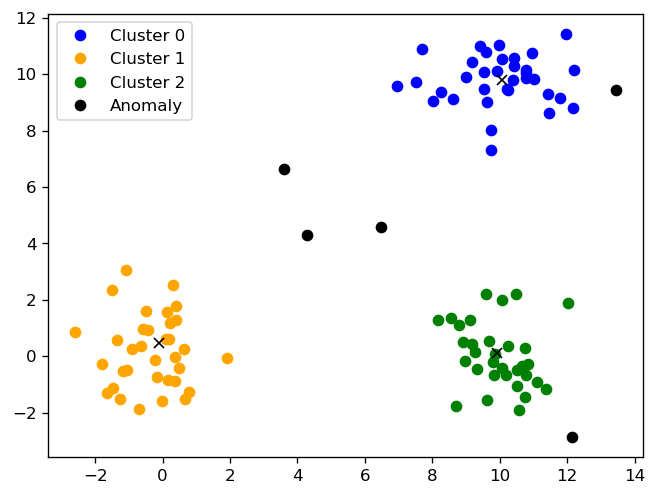

In [34]:
def plot_clusters_and_outliers(obs, n_clusters=3, n_anomalies=5):
    """
    Використовує k-середні для кластеризації та візуалізації аномалій.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(obs)
    centers = kmeans.cluster_centers_
    distances = np.min(kmeans.transform(obs), axis=1)

    # Визначаємо аномалії (найбільші відстані)
    anomaly_indices = np.argsort(-distances)[:n_anomalies]

    # Візуалізація
    plt.figure(figsize=(8, 6))
    plt.scatter(obs[:, 0], obs[:, 1], c=labels, cmap='viridis', alpha=0.5, label="Кластери")
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200, label="Центроїди")
    plt.scatter(obs[anomaly_indices, 0], obs[anomaly_indices, 1], c='black', marker='o', s=100, label="Аномалії")
    
    plt.legend()
    plt.title("Кластери та аномалії")
    plt.show()
    
plot_clusters_and_outliers(data, n_clusters=3, n_anomalies=5)

### Вправа №3

Ця вправа відноситься до методів на основі щільності (фактор локального викиду; Розділ 3).


A. Створіть функцію `do_lof_outlier_scores(obs, n_neighbors=3, n_anomalies=5)`, яка обчислює викидні оцінки за допомогою методу LOF. Пам’ятайте, що значення, які повертає реалізація sklearn, є негативними від того, що ми хочемо.

B. Застосуйте свою функцію до нашого набору даних $X2$, щоб отримати п’ять найбільших аномалій.

C. Наскільки метод LOF чутливий до `n_neighbors`? Спробуйте змінити `n_neighbor` (k=3,  k=2 ) на наборі даних `data`.

In [59]:
from sklearn.neighbors import LocalOutlierFactor


def do_lof_outlier_scores(obs, n_neighbors=3, n_anomalies=5):
    """
    Використовує метод LOF для оцінки викидів.
    Повертає найбільші аномалії (LOF оцінки та їх індекси).
    """
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    lof_scores = -lof.fit_predict(obs) * lof.negative_outlier_factor_  # Робимо значення позитивними

    # Визначаємо аномалії (найбільші значення LOF)
    anomaly_idx = np.argsort(-lof_scores)[:n_anomalies]
    return lof_scores[anomaly_idx], anomaly_idx

In [60]:
do_lof_outlier_scores(X2, n_neighbors=3,n_anomalies=5)

(array([1.2154, 1.2091, 1.0333, 1.012 , 0.9554]),
 array([5, 6, 3, 1, 2], dtype=int64))

Оцінки вищі 1 можна вважати аномаліями при к=3:

In [61]:
print_ranked_scores(data, do_lof_outlier_scores(data, n_neighbors=3)[0])

Rank  Point		Score
------------------------------
  1.  [-0.1857 -2.1364]		1.4289
  2.  [0.9669 1.901 ]		1.4002
  3.  [10.712   9.1415]		1.3998
  4.  [10.3722 -0.1562]		1.3680
  5.  [8.949 9.053]		1.3098


Оцінки вищі 1 можна вважати аномаліями при к=2:

In [62]:
print_ranked_scores(data, do_lof_outlier_scores(data, n_neighbors=2)[0])

Rank  Point		Score
------------------------------
  1.  [-0.1857 -2.1364]		1.4598
  2.  [0.9669 1.901 ]		1.4598
  3.  [10.712   9.1415]		1.4560
  4.  [10.3722 -0.1562]		1.4560
  5.  [8.949 9.053]		1.4558


Перші 5 аномальних точок співпали і при к=2, і при к=3:

In [63]:
print_ranked_scores(data, do_lof_outlier_scores(data, n_neighbors=3)[0])

Rank  Point		Score
------------------------------
  1.  [-0.1857 -2.1364]		1.4289
  2.  [0.9669 1.901 ]		1.4002
  3.  [10.712   9.1415]		1.3998
  4.  [10.3722 -0.1562]		1.3680
  5.  [8.949 9.053]		1.3098


### Вправа №4

Ця вправа відноситься до методів на основі щільності (DBSCAN; Розділ 4).

Використайте вже раніше згенерований датасет (data).

Застосуйте DBSCAN для виявлення аномалій. При цьому спробуйте змінювати параметри eps та min_samples, щоб виявити ті ж 5 аномалій або близькі до них. Що відбувається із кількістю кластерів?

Порівняйте отримані результати з методм вправи 2. 

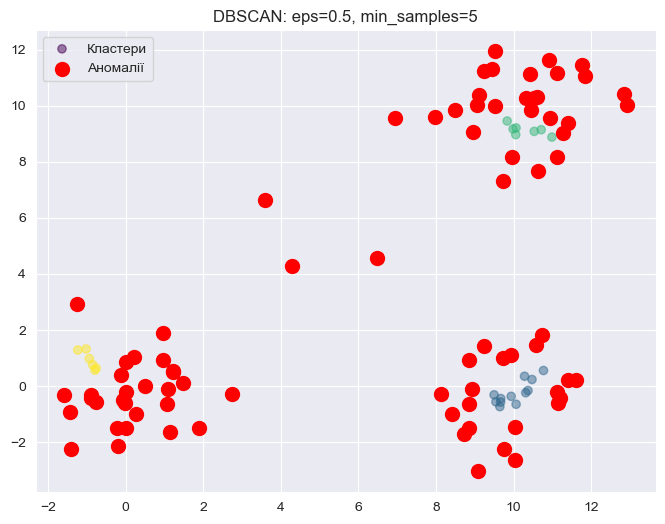

In [65]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

def plot_dbscan_clusters_and_anomalies(obs, eps=0.5, min_samples=5):
    """
    Використовує DBSCAN для кластеризації та візуалізації аномалій.
    """
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(obs)
    
    # Визначаємо аномалії (шум -1)
    anomaly_idx = np.where(labels == -1)[0]

    # Візуалізація
    plt.figure(figsize=(8, 6))
    plt.scatter(obs[:, 0], obs[:, 1], c=labels, cmap='viridis', alpha=0.5, label="Кластери")
    plt.scatter(obs[anomaly_idx, 0], obs[anomaly_idx, 1], c='red', marker='o', s=100, label="Аномалії")
    
    plt.legend()
    plt.title(f"DBSCAN: eps={eps}, min_samples={min_samples}")
    plt.show()

# Приклад використання:
plot_dbscan_clusters_and_anomalies(data, eps=0.5, min_samples=5)
